In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[0,0],[1,1],[1,0],[0,1]],
                              shuffle=True, cluster_std=0.15)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[0,0],[1,1],[1,0],[0,1]],
                            shuffle=True, cluster_std=0.15)

In [3]:
# 15번째 sample까지만 print

for i, x in enumerate(x_train):
    print(x, y_train[i])
    if i == 15 : break

[ 1.0094852  -0.00744923] 2
[0.99131521 0.12167863] 2
[ 0.76178805 -0.0216883 ] 2
[0.92143714 0.18785035] 2
[1.09855782 0.0229721 ] 2
[-0.11143314 -0.05100712] 0
[0.11324841 0.99878996] 3
[0.91657943 0.19675542] 2
[ 0.88901225 -0.09471989] 2
[ 0.11439003 -0.20704055] 0
[0.01860535 0.29462511] 0
[ 1.17329081 -0.12247994] 2
[-0.10793555  1.15154638] 3
[ 0.00127633 -0.14489886] 0
[0.8610125  0.97535163] 1
[0.00749653 0.88264466] 3


In [4]:
# label 0, 1 -> 0으로 매핑
# label 2, 3 -> 1로 매핑

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

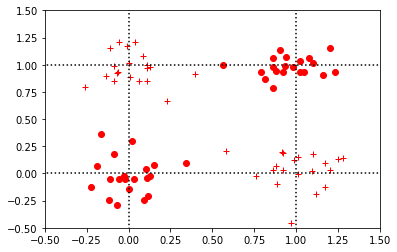

In [5]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.plot([-1, 2], [0,0], linestyle = ":", color = 'k')
plt.plot([-1, 2], [1,1], linestyle = ":", color = 'k')
plt.plot([0, 0], [-1, 2], linestyle = ":", color = 'k')
plt.plot([1, 1], [-1,2], linestyle = ":", color = 'k')

plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

In [6]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
print(y_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])
(80,)


In [7]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            ### 수정 ###
            # self.linear_2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            ############
            self.linear_last = torch.nn.Linear(self.hidden_size, 1)   # Binary Classification(classes: 2)
            self.sigmoid = torch.nn.Sigmoid()                      # 0~1
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu1 = self.relu(linear1)
            linear2 = self.linear_last(relu1)
            output = self.sigmoid(linear2)
            return output

In [59]:
learning_rate = 0.05
epochs = 2000
hidden_size = 10

### Model Initialize ###
model = NeuralNet(2, hidden_size)   # (Input size, Hidden size)
criterion = torch.nn.BCELoss()  # Binary Cross-Entropy  
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # Stochastic Gradient Descent

In [60]:
print(model)

NeuralNet(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (linear_last): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [61]:
# model.eval(): Gradient Backpropagation(역전파)를 중지 -> Validation 및 Test 시에 사용
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7407289147377014


In [62]:
model.train()   # Gradient Update 실행.
optimizer.zero_grad()   # Gradient 초기화
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward() # Backpropagation
optimizer.step()

In [63]:
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        train_losses.append(train_loss.item())
        torch.save(model.state_dict(), './model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7272266149520874
Train loss at 100 is 0.6748193502426147
Train loss at 200 is 0.6414942145347595
Train loss at 300 is 0.5937474966049194
Train loss at 400 is 0.5385233759880066
Train loss at 500 is 0.47572678327560425
Train loss at 600 is 0.408318430185318
Train loss at 700 is 0.3425472676753998
Train loss at 800 is 0.28501036763191223
Train loss at 900 is 0.23808178305625916
Train loss at 1000 is 0.20109887421131134
Train loss at 1100 is 0.17205795645713806
Train loss at 1200 is 0.14953242242336273
Train loss at 1300 is 0.13176670670509338
Train loss at 1400 is 0.11756988614797592
Train loss at 1500 is 0.1060103178024292
Train loss at 1600 is 0.09647341072559357
Train loss at 1700 is 0.08850883692502975
Train loss at 1800 is 0.08179562538862228
Train loss at 1900 is 0.07605550438165665


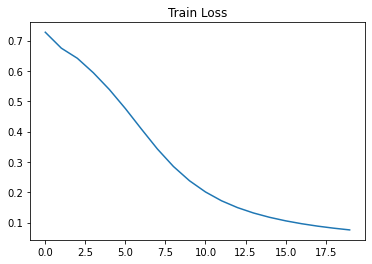

In [64]:
# train loss 그래프

plt.plot(train_losses)
plt.title('Train Loss')
plt.show()

In [65]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.18234756588935852


In [66]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 0.0124,  0.4432],
        [-1.1042, -1.1152],
        [-1.7372, -1.7545],
        [-0.2131,  0.6295],
        [ 0.4290, -0.6771],
        [ 0.6242,  0.6476],
        [ 0.0809, -0.5346],
        [-0.0282, -0.0241],
        [ 2.1591,  2.4063],
        [-0.8572, -0.8657]])), ('linear_1.bias', tensor([ 0.3344,  0.9920,  1.5606,  0.3400,  0.2385,  1.2609, -0.3967,  0.0228,
        -2.3613,  0.7700])), ('linear_last.weight', tensor([[ 0.2067, -1.6618, -2.7813,  0.1600,  0.6943,  1.1377, -0.1344, -0.1117,
         -3.9148, -1.4392]])), ('linear_last.bias', tensor([1.3877]))])


In [67]:
# 새로운 모델에 학습된 가중치 로드

new_model = NeuralNet(2, hidden_size)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [0, 1]이 레이블 1을 가질 확률은 {}'.format\
      (new_model(torch.FloatTensor([0,1])).item()))

벡터 [0, 1]이 레이블 1을 가질 확률은 0.9758414030075073


In [68]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [69]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1.])
tensor(95.)


In [70]:
# Train epoch마다 성능 평가

for i in range(0,2000,100):
    new_model = NeuralNet(2, hidden_size)
    new_model.load_state_dict(torch.load('./model_epoch{}.pt'.format(i)))
    new_model.eval()
    print("======epoch : {} =======".format(i))
    print(binary_acc(new_model(x_test), y_test))

======epoch : 0 =======
tensor(50.)
======epoch : 100 =======
tensor(55.)
======epoch : 200 =======
tensor(70.)
======epoch : 300 =======
tensor(85.)
======epoch : 400 =======
tensor(90.)
======epoch : 500 =======
tensor(95.)
======epoch : 600 =======
tensor(95.)
======epoch : 700 =======
tensor(95.)
======epoch : 800 =======
tensor(95.)
======epoch : 900 =======
tensor(95.)
======epoch : 1000 =======
tensor(95.)
======epoch : 1100 =======
tensor(95.)
======epoch : 1200 =======
tensor(95.)
======epoch : 1300 =======
tensor(95.)
======epoch : 1400 =======
tensor(95.)
======epoch : 1500 =======
tensor(95.)
======epoch : 1600 =======
tensor(95.)
======epoch : 1700 =======
tensor(95.)
======epoch : 1800 =======
tensor(95.)
======epoch : 1900 =======
tensor(95.)
